## Spatial Information Retrieval


In [1]:
## Required python libraries
import pandas as pd
import numpy as np
import scipy as sp
import scipy.signal
import os
import math
import sys
from scipy.interpolate import griddata

# to make this notebook's output stable across runs
np.random.seed(42)

pd.plotting.register_matplotlib_converters()

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
%matplotlib inline
import seaborn as sns
import librosa
import matplotlib.font_manager as font_manager

# -----------------Scikit-Learn ≥0.20 is required-------
import sklearn
assert sklearn.__version__ >= "0.20"
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler


In [2]:
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2.50

In [3]:
# ------------------- plotly visualizatoin----------------------------------
from PIL import Image
import plotly.io as pio
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from skimage import data

import scaleogram as scg 
from glob import glob
import glob
import scipy
from scipy.signal import welch
import wave                    # library handles the parsing of WAV file headers
import pywt
import soundfile as sf
import matplotlib.font_manager as font_manager

In [4]:
# Where to save the figures, and dataset locations
PROJECT_ROOT_DIR = "../../"

Multimodal_handcrafted_PATH = os.path.join("/home/chenlequn/Dataset/Multimodal_AM_monitoring/Handcrafted")
Audio_extracted_feature_PATH = os.path.join("/home/chenlequn/Dataset/Multimodal_AM_monitoring/Handcrafted/Acoustic_feature")
Raw_experiment_csv_PATH = os.path.join(Multimodal_handcrafted_PATH, "Raw_multisensor_feature")
Thermal_feature_csv_PATH = os.path.join(Multimodal_handcrafted_PATH, "Thermal_feature", 'csv')
Spatiotemporal_registered_PATH = os.path.join(Multimodal_handcrafted_PATH, "Spatiotemporal_registered")
# IMAGE_PATH = os.path.join(PROJECT_ROOT_DIR, "result_images", 'handcrafted_feature', 'sample_22')
# HTML_PATH = os.path.join(PROJECT_ROOT_DIR, "html", 'multimodal_experiment', "sample_22")

# os.makedirs(IMAGE_PATH, exist_ok=True)
# os.makedirs(HTML_PATH, exist_ok=True)

## function for automatically save the diagram/graph into the folder 
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGE_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

### import spatiotemporal fused dataset

In [5]:
dataset_21_file = os.path.join(Spatiotemporal_registered_PATH, "sample_21_resampled.csv")
dataset_22_file = os.path.join(Spatiotemporal_registered_PATH, "sample_22_resampled.csv")
dataset_23_file = os.path.join(Spatiotemporal_registered_PATH, "sample_23_resampled.csv")
dataset_24_file = os.path.join(Spatiotemporal_registered_PATH, "sample_24_resampled.csv")
dataset_26_file = os.path.join(Spatiotemporal_registered_PATH, "sample_26_resampled.csv")
label_file = os.path.join(Multimodal_handcrafted_PATH, 'label.csv')

In [6]:
# dropna, create pandas dataframe
labels = pd.read_csv(label_file).dropna(axis=0)

def reset_dataset(dataset_filename):
    dataset = pd.read_csv(dataset_filename).dropna(axis=0)
    # dataset = dataset[dataset.layer != 0] # remove all the '0' layer
    # resetting the DataFrame index
    dataset = dataset.reset_index()
    return dataset

In [7]:
dataset_21 = reset_dataset(dataset_21_file)
dataset_22 = reset_dataset(dataset_22_file)
dataset_23 = reset_dataset(dataset_23_file)
dataset_24 = reset_dataset(dataset_24_file)
dataset_26 = reset_dataset(dataset_26_file)

In [9]:
df_selected = dataset_26.iloc[:, :5]
df_selected

,index,Unnamed: 0,X,Y,Z
0,0,0,0.053223,0.332886,0.129822
1,1,1,0.053182,0.332865,0.129832
2,2,2,0.053141,0.332845,0.129842
3,3,3,0.053101,0.332825,0.129852
4,4,4,0.053060,0.332821,0.129846
...,...,...,...,...,...
326595,326595,326595,0.049878,0.333378,19.717114
326596,326596,326596,0.049890,0.333386,19.717105
326597,326597,326597,0.049898,0.333388,19.717104
326598,326598,326598,0.049902,0.333388,19.717105


<AxesSubplot:>

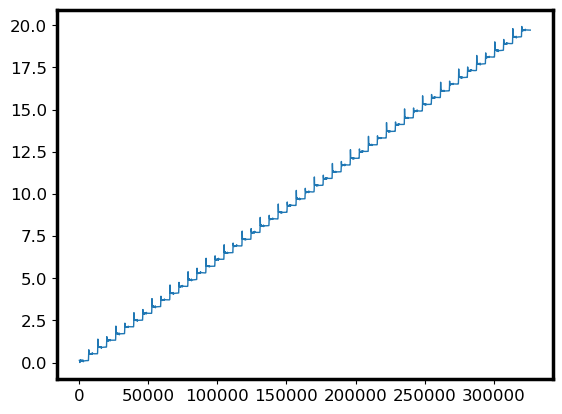

In [10]:
df_selected['Z'].plot(linewidth=1)

In [18]:
from scipy.signal import savgol_filter
length = 10986

# 5141 - sample 21
# 10987 - sample 26

X = scipy.signal.resample(df_selected["X"].to_numpy(), length)
Y = scipy.signal.resample(df_selected["Y"].to_numpy(), length)
Z = scipy.signal.resample(df_selected["Z"].to_numpy(), length)

# X_df = pd.DataFrame(X, columns=["X"]).rolling(20, min_periods=1).mean()
# Y_df = pd.DataFrame(Y, columns=["Y"]).rolling(20, min_periods=1).mean()
# Z_df = pd.DataFrame(Z, columns=["Z"]).rolling(20, min_periods=1).mean()
X_df = pd.DataFrame(X, columns=["X"])
Y_df = pd.DataFrame(Y, columns=["Y"])
Z_df = pd.DataFrame(Z, columns=["Z"])


# X_smooth = savgol_filter(X, window_length=5, polyorder=2)
# Y_smooth = savgol_filter(Y, window_length=5, polyorder=2)
# Z_smooth = savgol_filter(Z, window_length=5, polyorder=2)

dataframe_resampled = pd.concat([X_df, Y_df, Z_df], axis=1)

In [19]:
dataframe_resampled

,X,Y,Z
0,0.051261,0.332409,9.593398
1,0.053637,0.333638,-1.620712
2,0.052480,0.332042,1.079153
3,0.053354,0.334101,-0.517956
4,0.052477,0.331523,0.617860
...,...,...,...
10981,0.049866,0.333670,20.111111
10982,0.049612,0.332770,19.226752
10983,0.049823,0.333603,20.365324
10984,0.049747,0.332576,18.765931


<AxesSubplot:>

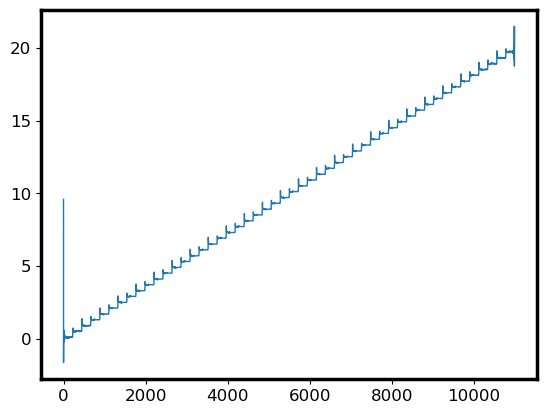

In [20]:
dataframe_resampled['Z'].plot(linewidth=1)

In [21]:
dataframe_resampled.to_csv('26_position.csv', index=False)